In [1]:
import h5py
import time, copy, sys, os
import scipy.stats as ss
import numpy as np
import scipy
from scipy.stats import gaussian_kde
from scipy.special import logsumexp
from scipy.signal import savgol_filter

%matplotlib inline
import seaborn
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter

In [2]:
import sys
path = "../"
sys.path.append(path)

import functions, models, gnobs, analysis_data, post_process
import read_pe_samples
from conversions import *

In [3]:
params = {'font.family': 'DejaVu Serif',
          'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'xtick.direction':'in',
          'ytick.direction':'in',
          'ytick.labelsize':'large','font.size':15}
plt.rcParams.update(params)
inches_to_cm = 2.54
figsize = (40/inches_to_cm, 13/inches_to_cm)
dpi = 300

colours = {}
colours['Mixed'] = '#1f77b4'
colours['Single'] = '#ff7f0e'

In [4]:
# Read data
nsamp = 4250
ifar_thr = 1.0
injections, pe = {}, {}
pe_dir = '../gw_data/pe/*o1o2*BBH*.hdf5'
pe['o1o2'] = read_pe_samples.read_pesamples(pe_dir, ifar_thr, nsamp)
pe_dir = '../gw_data/pe/*o3a*BBH*.hdf5'
pe['o3a'] = read_pe_samples.read_pesamples(pe_dir, ifar_thr, nsamp)
pe_dir = '../gw_data/pe/*o3b*BBH*.hdf5'
pe['o3b'] = read_pe_samples.read_pesamples(pe_dir, ifar_thr, nsamp)

fname = '../gw_data/injections/o1o2_bbhpop_siminj.hdf'
injections['o1o2'] = functions.read_injections_o1o2(fname)
fname = '../gw_data/injections/endo3_bbhpop-LIGO-T2100113-v9-1238166018-15843600.hdf5'
injections['o3a'] = functions.read_injections_o3(fname, ifar_thr)
fname = '../gw_data/injections/endo3_bbhpop-LIGO-T2100113-v9-1256655642-12905976.hdf5'
injections['o3b'] = functions.read_injections_o3(fname, ifar_thr)

for obsrun in pe.keys():
    for obs in pe[obsrun].keys():
        redshifts = pe[obsrun][obs]['redshift']
        q = pe[obsrun][obs]['q']
        pe[obsrun][obs]['logq'] = np.log(q)
        pe[obsrun][obs]['log1pz'] = np.log1p(redshifts)
        pe[obsrun][obs]['dilated_dcovdz'] = z_to_dcovdz(redshifts) / (1 + redshifts)

for obsrun in injections.keys():
    redshifts = injections[obsrun]['z_rec']
    injections[obsrun]['log1pz'] = np.log1p(redshifts)
    injections[obsrun]['dilated_dcovdz'] = z_to_dcovdz(redshifts) / (1 + redshifts)

In [5]:
choice = ''
fname = path + 'results/o1o2o3_sfr_1pz_ifar_1peryear_mixture_ng11.hdf5'

directory = path + 'plots/' + fname.split('/')[-1][:-5]
print (directory)
if not os.path.exists(directory):
    os.makedirs(directory)

../plots/o1o2o3_sfr_1pz_ifar_1peryear_mixture_ng11


In [6]:
results = {}
results['Mixed'] = functions.read_results(fname)
fname = '../results/o1o2o3_sfr_1pz_ifar_1peryear_ng11.hdf5'
results['Single'] = functions.read_results(fname)

In [7]:
r = results['Mixed']
nobs = r['args_sampler']['nobs']
ngauss = r['args_sampler']['ngauss']

mass_ax = r['args_ppd']['mass_ax']
mch_ax = r['args_ppd']['mch_ax']
q_ax = r['args_ppd']['q_ax']
sz_ax = r['args_ppd']['sz_ax']

In [8]:
print ('Model | No. of observations | Number of Posterior Samples | Marginal Likelihood | Maximum Likelihood')
for key in results.keys():
    res = results[key]
    margl = res['posteriors']['margl']
    print(key, '|', res['args_sampler']['nobs'], '|', \
          len(margl)
          , '|', np.round(logsumexp(margl) - np.log(len(margl)), 1), '|', 
          np.round(np.max(res['posteriors']['log_lkl']), 1))

Model | No. of observations | Number of Posterior Samples | Marginal Likelihood | Maximum Likelihood
Mixed | 69 | 2000 | -201.4 | -195.0
Single | 69 | 2000 | -200.6 | -193.4


### Mass Plots

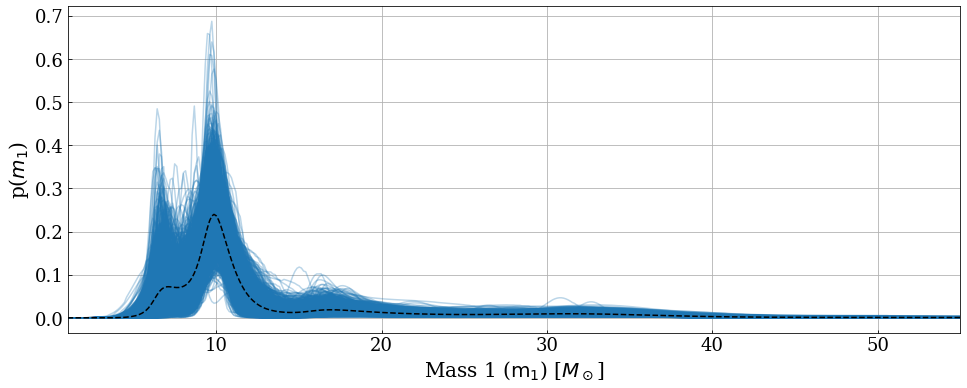

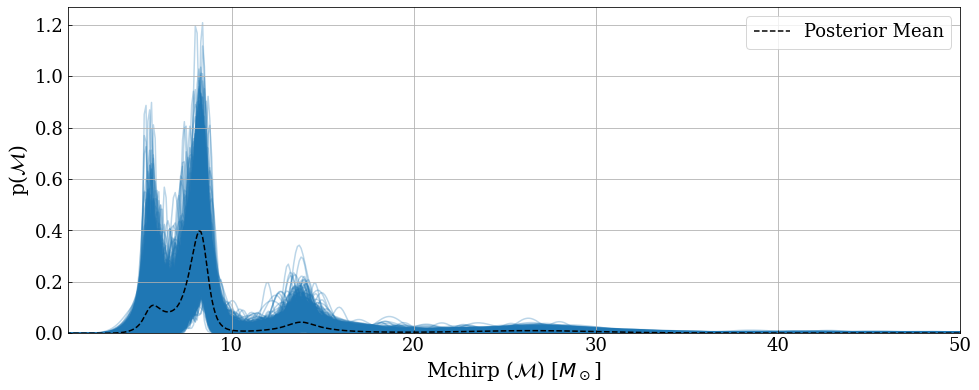

In [9]:
key = 'Mixed'
post_pdfs_mass1 = results[key]['ppd']['post_pdf_mass1']
post_pdfs_mch = results[key]['ppd']['post_pdf_mch']
fig = plt.figure(figsize = (16.0, 6.0))
for ii, pdf in enumerate(post_pdfs_mass1):
    plt.plot(mass_ax, pdf, color = colours[key], alpha = 0.3)

plt.plot(mass_ax, np.mean(post_pdfs_mass1, axis = 0), color = 'black', linestyle = '--')
plt.xlim(1., 55.)
plt.grid()
plt.xlabel('Mass 1 ($\mathrm{m_1}$) [$M_\odot$]', fontsize=20)
plt.ylabel('p($m_1$)', fontsize=20)
plt.savefig(directory + '/sphagetti_mass1.jpg', dpi = dpi, bbox_inches = 'tight')

fig = plt.figure(figsize = (16., 6.0))
for ii, pdf in enumerate(post_pdfs_mch):
    plt.plot(mch_ax, pdf, color = colours[key], alpha = 0.3, zorder = 1)

plt.plot(mch_ax, np.mean(post_pdfs_mch, axis = 0), linestyle = '--', color = 'black', label = 'Posterior Mean')

plt.xlabel('Mchirp ($\mathcal{M}$) [$M_\odot$]', fontsize=20)
plt.ylabel('p($\mathcal{M}$)', fontsize=20)
plt.legend(loc = 'upper right')
plt.xlim(1.,50.)
plt.ylim(0, None)
plt.grid()
plt.savefig(directory + '/sphagetti_mchirp.jpg', dpi = dpi, bbox_inches  = 'tight')

In [10]:
mean_mch_1g = {}
for key in ['Mixed']:
    mean_mch_1g[key] = [np.mean(p[p<11]) for p in results[key]['ppd']['ppd_mch']]

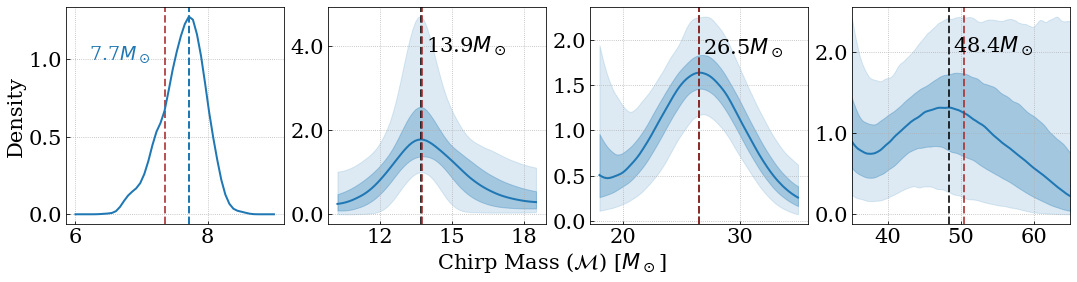

In [11]:
#Extract peaks in O3 data
breaks = np.array([5, 11., 18., 35., 70.])
key = 'Mixed'
res = results[key]
ppd_mch = res['ppd']['ppd_mch']
p5, p25, p50, p75, p95 = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mch'], res['posteriors']['rate'])
selp50 = p50[(mch_ax > 7.5) & (mch_ax < 11.)]
frac_drop = np.round(np.max(selp50) / np.min(selp50), 1)
selp50 = p50[(mch_ax > 11.0) & (mch_ax < 14.5)]
frac_rise = np.round(np.max(selp50) / np.min(selp50), 1)

fig, axs = plt.subplots(1, 4, figsize = (18.0, 4.0))
gloc = []
perc_kept = 0.95
ii = 0
fnts = 21
segl = len(mch_ax) // 50 if len(mch_ax) // 50 % 2 == 1 else len(mch_ax) // 50 - 1
for jj in [0, 1, 2, 3]:
    idx = np.where((ppd_mch > breaks[ii]) & (ppd_mch < breaks[ii + 1]))
    data = ppd_mch[idx]

    maxllkl = -np.inf
    for aa in np.arange(0.52, 8.0, .05):
        llkl = np.sum(np.log(models.powerlaw_pdf(data, breaks[ii], breaks[ii + 1], aa)))
        if llkl > maxllkl:
            alfa = aa
            maxllkl = llkl
    idx_mchaxsel = np.where((mch_ax > breaks[ii]) & (mch_ax < breaks[ii + 1]))
    mchaxsel = mch_ax[idx_mchaxsel]
    ratios = []
    for pdf in post_pdfs_mch:
        truncpdf = pdf[idx_mchaxsel]
        nrm = np.sum(truncpdf) * (mch_ax[1] - mch_ax[0])
        truncpdf /= nrm
        ratios.append(truncpdf / models.powerlaw_pdf(mch_ax[idx_mchaxsel], breaks[ii], breaks[ii + 1], alfa))
    
    ratios_ll90 = savgol_filter(np.percentile(np.array(ratios), 5., axis = 0), segl, 2)
    ratios_ul90 = savgol_filter(np.percentile(np.array(ratios), 95., axis = 0), segl, 2)
    ratios_ll50 = savgol_filter(np.percentile(np.array(ratios), 25., axis = 0), segl, 2)
    ratios_ul50 = savgol_filter(np.percentile(np.array(ratios), 75., axis = 0), segl, 2)
    mean_ratios = savgol_filter(np.percentile(np.array(ratios), 50., axis = 0), segl, 2)
    gloc.append(mch_ax[idx_mchaxsel][np.argmax(savgol_filter(mean_ratios, 9, 5))])
    
    if jj > 0:
        axs[jj].plot(mch_ax[idx_mchaxsel], mean_ratios, linewidth = 2.0, color = colours[key])
        axs[jj].fill_between(mch_ax[idx_mchaxsel], ratios_ll90, ratios_ul90, alpha = 0.15, color = colours[key])
        axs[jj].fill_between(mch_ax[idx_mchaxsel], ratios_ll50, ratios_ul50, alpha = 0.3, color = colours[key])
        axs[jj].axvline(x = gloc[-1], color = 'black', linestyle = '--', alpha = 0.8, linewidth = 2.0)
        axs[jj].text(gloc[-1] * 1.012, np.max(ratios_ul90) * 0.82, str(np.round(gloc[-1], 1)) + '$M_\odot$', fontsize=fnts)

    axs[jj].grid(ls=':')
    axs[jj].xaxis.set_major_formatter(FormatStrFormatter("%.0f"))
    axs[jj].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    axs[jj].tick_params(axis='both', which='major', labelsize=fnts)

    if ii == 3:
        plt.xlim(breaks[-2], 65.)
    ii += 1
    
#The location of the third peak is best measured
ii = -2
for jj in [0, 1, 2, 3]:
    axs[jj].axvline(x = gloc[2] * (perc_kept * 2) ** ii, color = 'brown', linestyle = '--', alpha = 0.8, linewidth = 2.0)
    ii += 1

mchax = np.linspace(6., 9.0, 50)
for ii, key in enumerate(['Mixed']):
    mean_mch_1g = [np.mean(p[p<11]) for p in results[key]['ppd']['ppd_mch']]
    kde = gaussian_kde(mean_mch_1g)
    pdf = kde(mchax)
    axs[0].plot(mchax, pdf, linewidth = 2.0, color = colours[key])
    axs[0].axvline(x = mchax[np.argmax(pdf)], color = colours[key], linestyle = '--', linewidth = 2.0)
    axs[0].text(6.2 + ii * 1.8, 1.0, str(np.round(mchax[np.argmax(pdf)], 1)) + '$M_\odot$', fontsize=fnts - 2, color = colours[key])
    
fig.text(0.08, 0.5, 'Density', va='center', rotation='vertical', fontsize=fnts)
fig.text(0.5, -0.03, 'Chirp Mass ($\mathcal{M}$) [$M_\odot$]', ha='center', fontsize=fnts)
plt.savefig(directory + '/normalised_peaks.jpg', dpi = dpi, bbox_inches = 'tight')

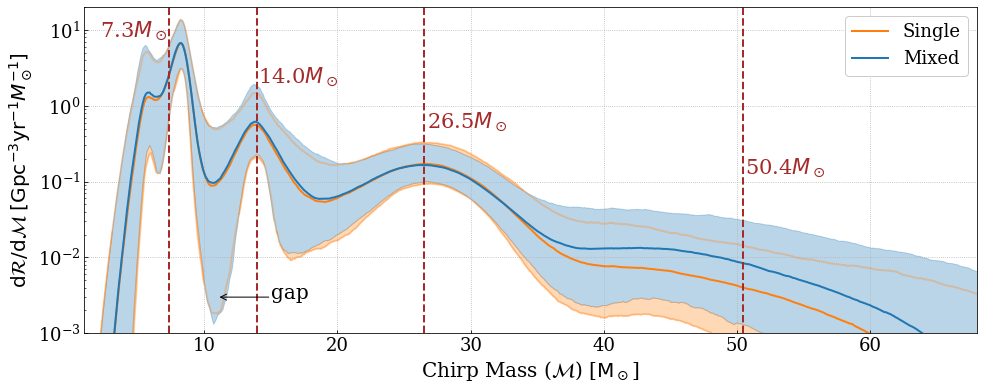

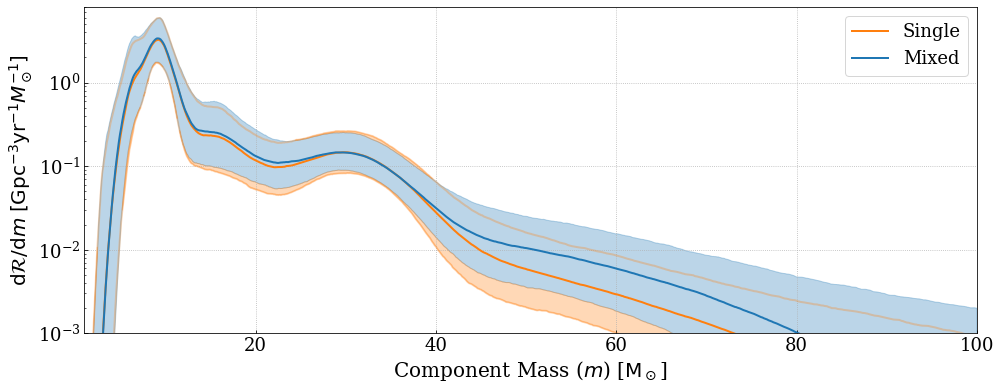

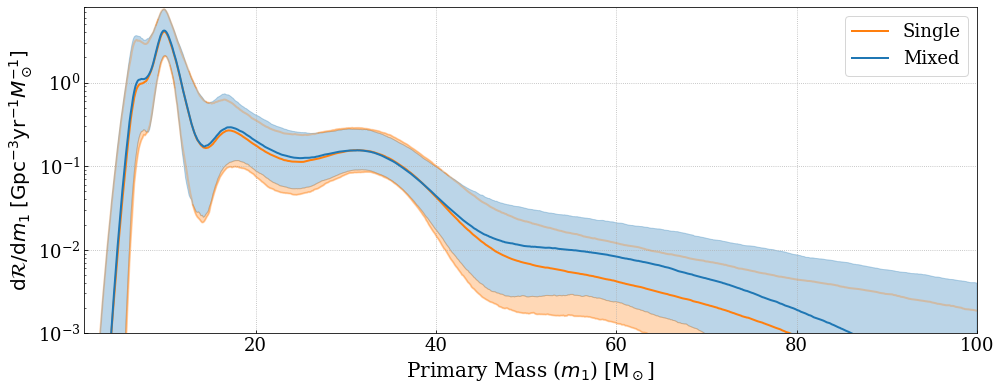

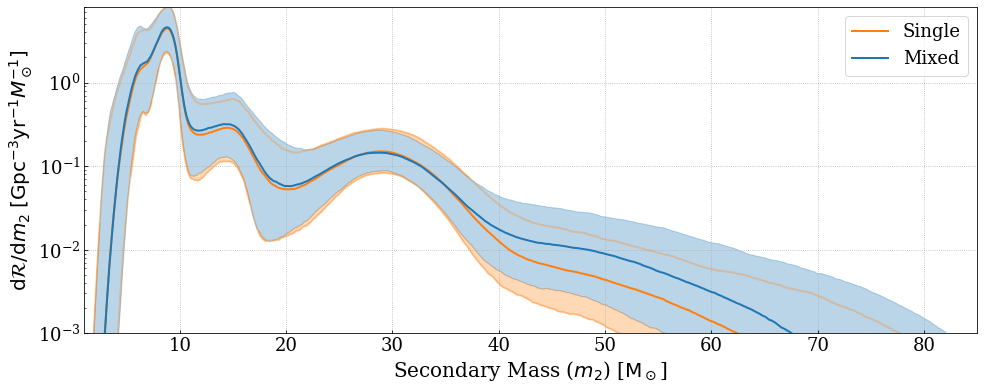

In [12]:
k = list(results.keys())[0]
r = results[k]
mass_ax = r['args_ppd']['mass_ax']
mch_ax = r['args_ppd']['mch_ax']
keys = ['Single', 'Mixed']
fig = plt.figure(figsize = (16.0, 6.0))
p5, p50, p95 = {}, {}, {}
for ii, key in enumerate(keys):
    res = results[key]
    p5[key], _, p50[key], _, p95[key] = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mch'], res['posteriors']['rate'])
key = 'Single'
idx = np.where(p95['Mixed'] > p95['Single'])
plt.plot(mch_ax, p50[key], linewidth = 2., label = key, color = colours[key])
p = plt.plot(mch_ax, p5[key], color = colours[key], alpha = 0.3, linewidth = 2.0)
p = plt.plot(mch_ax, p95[key], color = colours[key], alpha = 0.3, linewidth = 2.0)
key = 'Mixed'
plt.plot(mch_ax, p50[key], linewidth = 2., label = key, color = colours[key])
plt.fill_between(mch_ax, p5[key], p95[key], alpha = 0.3, color = colours[key])
plt.fill_between(mch_ax, p5['Single'], p5['Mixed'], alpha = 0.3, color = colours['Single'], where=(p5['Mixed'] > p5['Single']))
plt.fill_between(mch_ax, p95['Mixed'], p95['Single'], alpha = 0.3, color = colours['Single'], where=(p95['Single'] > p95['Mixed']))

shift = [5.2, -0.1, -0.2, -0.2]
for ii in range(-2, 2):
    exp_loc = gloc[2] * (perc_kept * 2) ** ii
    plt.axvline(x = exp_loc, color = 'brown', linestyle = '--', linewidth = 2.0)
    plt.text(exp_loc - shift[ii + 2], .5/4 ** ii, str(np.round(exp_loc, 1)) + '$M_\odot$', fontsize=fnts, color = 'brown')
    ii +=1
mmch = 11.
plt.annotate(text='', xy=(mmch,.003), xytext=(mmch + 4.,.003), arrowprops=dict(arrowstyle='->'), color = 'black')
plt.text(mmch + 4., .0028, 'gap', fontsize=20)

plt.xlabel('Chirp Mass ($\mathcal{M}$) [$\mathrm{M}_\odot$]', fontsize=20)
plt.ylabel('$\mathrm{d}\mathcal{R}/\mathrm{d}\mathcal{M}\;[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}M_\odot^{-1}]$',fontsize=20)
plt.xlim(1, 68.)
plt.ylim(1e-3, 20.)
plt.yscale('log')
plt.grid(ls=':')
plt.legend(loc = 'best', framealpha = 1.0)
plt.savefig(directory + '/confidence_mchirp.jpg', dpi = dpi, bbox_inches = 'tight')

keys = ['Single', 'Mixed']
fig = plt.figure(figsize = (16.0, 6.0))
p5, p50[key], p95 = {}, {}, {}
for ii, key in enumerate(keys):
    res = results[key]
    p5[key], _, p50[key], _, p95[key] = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mass'], res['posteriors']['rate'])
    plt.plot(mass_ax, p50[key], linewidth = 2., label = key, color = colours[key])
key = 'Mixed'
plt.fill_between(mass_ax, p5[key], p95[key], alpha = 0.3, color = colours[key])
plt.fill_between(mass_ax, p5['Single'], p5['Mixed'], alpha = 0.3, color = colours['Single'], where=(p5['Mixed'] > p5['Single']))
plt.fill_between(mass_ax, p95['Mixed'], p95['Single'], alpha = 0.3, color = colours['Single'], where=(p95['Single'] > p95['Mixed']))
key = 'Single'
idx = np.where(p95['Mixed'] > p95['Single'])
p = plt.plot(mass_ax, p5[key], color = colours[key], alpha = 0.3, linewidth = 2.0)
p = plt.plot(mass_ax, p95[key], color = colours[key], alpha = 0.3, linewidth = 2.0)

plt.xlabel('Component Mass ($m$) [$\mathrm{M}_\odot$]', fontsize=20)
plt.ylabel('$\mathrm{d}\mathcal{R}/\mathrm{d}m\;[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}M_\odot^{-1}]$', fontsize=20)
plt.xlim(1, 100.)
plt.ylim(1e-3, 8.)
plt.yscale('log')
plt.grid(ls=':')
plt.legend(loc = 'best')
plt.savefig(directory + '/confidence_m.jpg', dpi = dpi, bbox_inches = 'tight')

fig = plt.figure(figsize = (16.0, 6.0))
p5, p50, p95 = {}, {}, {}
for ii, key in enumerate(keys):
    res = results[key]
    p5[key], _, p50[key], _, p95[key] = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mass1'], res['posteriors']['rate'])
    plt.plot(mass_ax, p50[key], linewidth = 2., label = key, color = colours[key])
key = 'Mixed'
plt.fill_between(mass_ax, p5[key], p95[key], alpha = 0.3, color = colours[key])
plt.fill_between(mass_ax, p5['Single'], p5['Mixed'], alpha = 0.3, color = colours['Single'], where=(p5['Mixed'] > p5['Single']))
plt.fill_between(mass_ax, p95['Mixed'], p95['Single'], alpha = 0.3, color = colours['Single'], where=(p95['Single'] > p95['Mixed']))
key = 'Single'
idx = np.where(p95['Mixed'] > p95['Single'])
p = plt.plot(mass_ax, p5[key], color = colours[key], alpha = 0.3, linewidth = 2.0)
p = plt.plot(mass_ax, p95[key], color = colours[key], alpha = 0.3, linewidth = 2.0)

plt.xlabel('Primary Mass ($m_1$) [$\mathrm{M}_\odot$]', fontsize=20)
plt.ylabel('$\mathrm{d}\mathcal{R}/\mathrm{d}m_1\;[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}M_\odot^{-1}]$', fontsize=20)
plt.xlim(1, 100.)
plt.ylim(1e-3, 8.)
plt.yscale('log')
plt.grid(ls=':')
plt.legend(loc = 'best')
plt.savefig(directory + '/confidence_m1.jpg', dpi = dpi, bbox_inches = 'tight')

fig = plt.figure(figsize = (16.0, 6.0))
p5, p50, p95 = {}, {}, {}
for ii, key in enumerate(keys):
    res = results[key]
    p5[key], _, p50[key], _, p95[key] = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_mass2'], res['posteriors']['rate'])
    plt.plot(mass_ax, p50[key], linewidth = 2., label = key, color = colours[key])
key = 'Mixed'
plt.fill_between(mass_ax, p5[key], p95[key], alpha = 0.3, color = colours[key])
plt.fill_between(mass_ax, p5['Single'], p5['Mixed'], alpha = 0.3, color = colours['Single'], where=(p5['Mixed'] > p5['Single']))
plt.fill_between(mass_ax, p95['Mixed'], p95['Single'], alpha = 0.3, color = colours['Single'], where=(p95['Single'] > p95['Mixed']))
key = 'Single'
idx = np.where(p95['Mixed'] > p95['Single'])
p = plt.plot(mass_ax, p5[key], color = colours[key], alpha = 0.3, linewidth = 2.0)
p = plt.plot(mass_ax, p95[key], color = colours[key], alpha = 0.3, linewidth = 2.0)

plt.xlabel('Secondary Mass ($m_2$) [$\mathrm{M}_\odot$]', fontsize=20)
plt.ylabel('$\mathrm{d}\mathcal{R}/\mathrm{d}m_2\;[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}M_\odot^{-1}]$', fontsize=20)
plt.xlim(1, 85.)
plt.ylim(1e-3, 8.)
plt.yscale('log')
plt.grid(ls=':')
plt.legend(loc = 'best')
plt.savefig(directory + '/confidence_m2.jpg', dpi = dpi, bbox_inches = 'tight')

### Mass Ratio and Spin - 1D, 2D

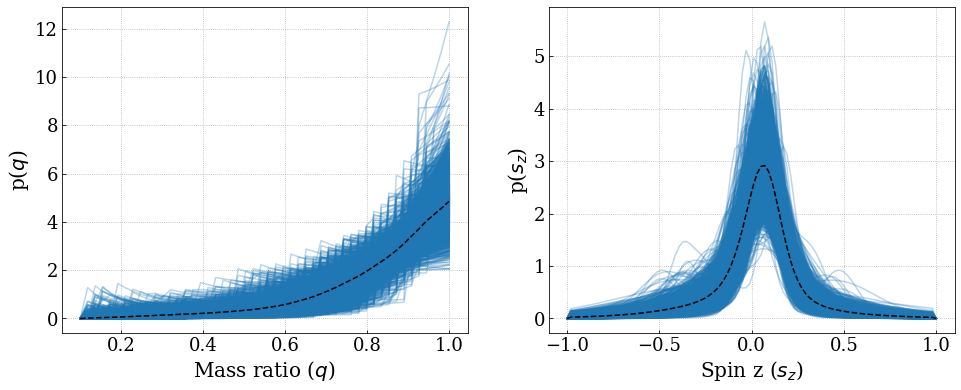

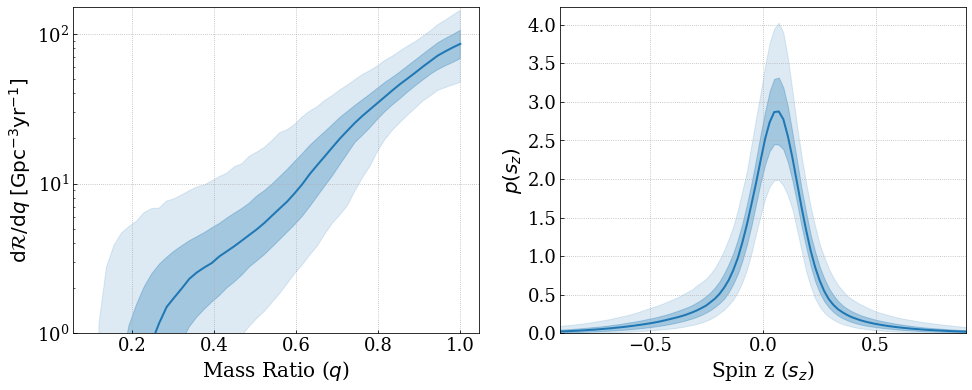

In [13]:
key = 'Mixed'
post_pdfs_q = results[key]['ppd']['post_pdf_q']
post_pdfs_sz = results[key]['ppd']['post_pdf_sz']
fig = plt.figure(figsize = (16.0, 6.0))
plt.subplot(1, 2, 1)
for ii, pdf in enumerate(post_pdfs_q):
    plt.plot(q_ax, pdf, color = colours[key], alpha = 0.3)

plt.plot(q_ax, np.mean(post_pdfs_q, axis = 0), color = 'black', linestyle = '--')
plt.grid(ls=':')
plt.xlabel('Mass ratio ($q$)', fontsize=20)
plt.ylabel('p($q$)', fontsize=20)
plt.subplot(1, 2, 2)
for ii, pdf in enumerate(post_pdfs_sz):
    plt.plot(sz_ax, pdf, color = colours[key], alpha = 0.3)

plt.plot(sz_ax, np.mean(post_pdfs_sz, axis = 0), color = 'black', linestyle = '--')
plt.grid(ls=':')
plt.xlabel('Spin z ($s_z$)', fontsize=20)
plt.ylabel('p($s_z$)', fontsize=20)

plt.savefig(directory + '/sphagetti_q_sz.jpg', dpi = dpi, bbox_inches = 'tight')

fig = plt.figure(figsize = (16.0, 6.0))
plt.subplot(1, 2, 1)
p5, p25, p50, p75, p95 = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_q'], res['posteriors']['rate'])
plt.plot(q_ax, p50, color = colours[key], linewidth = 2.0)
plt.fill_between(q_ax, p5, p95, alpha = 0.15, color = colours[key])
plt.fill_between(q_ax, p25, p75, alpha = 0.3, color = colours[key])
plt.grid(ls=':')
plt.ylim(1., None)
plt.yscale('log')
plt.xlabel('Mass Ratio ($q$)', fontsize=20)
plt.ylabel('$\mathrm{d}\mathcal{R}/\mathrm{d}q\;[\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}]$', fontsize=20)
plt.subplot(1, 2, 2)
p5, p25, p50, p75, p95 = post_process.get_DiffRate_intervals(res['ppd']['post_pdf_sz'], 1)
plt.plot(sz_ax, p50, color = colours[key], linewidth = 2.0)
plt.fill_between(sz_ax, p5, p95, alpha = 0.15, color = colours[key])
plt.fill_between(sz_ax, p25, p75, alpha = 0.3, color = colours[key])
plt.grid(ls=':')
plt.ylim(0, None)
plt.xlim(-0.9, 0.9)
plt.xlabel('Spin z ($s_z$)', fontsize=20)
plt.ylabel('$p(s_z)$', fontsize=20)

plt.savefig(directory + '/confidence_q_sz.jpg', dpi = dpi, bbox_inches = 'tight')

In [14]:
res = results['Mixed']
ngauss = res['args_sampler']['ngauss']
locs_mch = res['posteriors']['locs_mch']
stds_mch = res['posteriors']['stds_mch']
min_q = res['posteriors']['min_q']
alphas_q = res['posteriors']['alphas_q']
locs_sz = res['posteriors']['locs_sz']
stds_sz = res['posteriors']['stds_sz']
gwts = res['posteriors']['gwts']
rate = res['posteriors']['rate']
ppd_q = res['ppd']['ppd_q']

qax = np.linspace(np.min(ppd_q), 1., 51)
szax = np.linspace(-1, 1, 401)
xy, yx = np.meshgrid(qax, szax)
logxy = np.log(xy)

all_rate_qsz = []
for ii in range(len(rate)):
    post_pdf_qsz = 0
    for jj in range(ngauss):
        logpdf = models.powerlaw_logpdf(logxy, min_q[ii][jj], 1.0, alphas_q[ii][jj])
        rvs = ss.norm(loc = locs_sz[ii][jj], scale = stds_sz[ii][jj])
        logpdf += rvs.logpdf(yx)
        nrm = rvs.cdf(0.99) - rvs.cdf(-0.99)
        logpdf += np.log(gwts[ii][jj])
        post_pdf_qsz += np.exp(logpdf) / nrm
    if ii % 500 == 0:
        print (ii)
    rate_qsz = rate[ii] * post_pdf_qsz
    all_rate_qsz.append(rate_qsz)
    
mean_rate_qsz = np.mean(all_rate_qsz, axis = 0)
mean_rate_qsz = np.transpose(mean_rate_qsz)

p5_qsz, p25_qsz, p50_qsz, p75_qsz, p95_qsz = [], [], [], [], []
for ii, _ in enumerate(qax):
    pdf = mean_rate_qsz[ii]
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    p5_qsz.append(szax[np.where(cdf > 0.05)[0][0]])
    p25_qsz.append(szax[np.where(cdf > 0.25)[0][0]])
    p50_qsz.append(szax[np.where(cdf > 0.5)[0][0]])
    p75_qsz.append(szax[np.where(cdf > 0.75)[0][0]])
    p95_qsz.append(szax[np.where(cdf > 0.95)[0][0]])

0
500
1000
1500


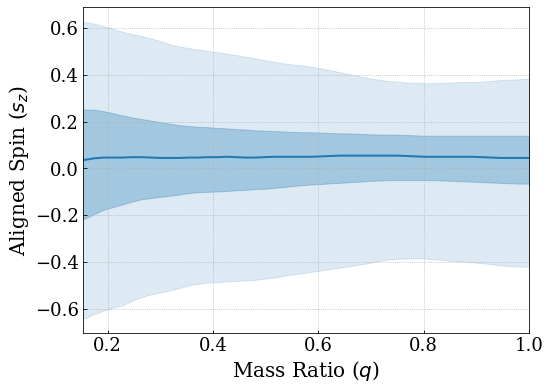

In [15]:
fig = plt.figure(figsize = (8.0, 6.0))
plt.plot(qax, savgol_filter(p50_qsz, 3, 1), color = colours[key], linewidth = 2.0)
plt.fill_between(qax, savgol_filter(p5_qsz, 3, 1), savgol_filter(p95_qsz, 3, 1), alpha = 0.15, color = colours[key])
plt.fill_between(qax, savgol_filter(p25_qsz, 3, 1), savgol_filter(p75_qsz, 3, 1), alpha = 0.3, color = colours[key])
plt.grid(ls=':')
plt.xlabel('Mass Ratio ($q$)', fontsize=20)
plt.ylabel('Aligned Spin ($s_z$)', fontsize=20)
plt.xlim(qax[0] + 0.05, qax[-1])
plt.savefig(directory + '/sz_vs_q.jpg', dpi = dpi, bbox_inches = 'tight')

### Mass Ratio and Spin Vs Chirp Mass

In [16]:
mchax = np.linspace(4., 64., 121)
szax = np.linspace(0, 1, 201)
xy, yx = np.meshgrid(mchax, szax)
all_rate_mchsz = []
for ii in range(len(rate)):
    post_pdf_mchsz = 0
    for jj in range(ngauss):
        rvs = ss.norm(loc = locs_mch[ii][jj], scale = stds_mch[ii][jj])
        logpdf = rvs.logpdf(xy)
        rvs = ss.norm(loc = np.abs(locs_sz[ii][jj]), scale = stds_sz[ii][jj])
        logpdf += rvs.logpdf(yx)
        nrm = rvs.cdf(0.99) - rvs.cdf(-0.99)
        logpdf += np.log(gwts[ii][jj])
        post_pdf_mchsz += np.exp(logpdf) / nrm
    if ii % 500 == 0:
        print (ii)
    rate_mchsz = rate[ii] * post_pdf_mchsz
    all_rate_mchsz.append(rate_mchsz)
    
mean_rate_mchsz = np.mean(all_rate_mchsz, axis = 0)
mean_rate_mchsz = np.transpose(mean_rate_mchsz)

p50_mchsz, p90_mchsz = [], []
for ii, _ in enumerate(mchax):
    pdf = mean_rate_mchsz[ii]
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    p50_mchsz.append(szax[np.where(cdf > 0.5)[0][0]])
    p90_mchsz.append(szax[np.where(cdf > 0.9)[0][0]])

mchax = np.linspace(4., 64., 121)
qax = np.linspace(np.min(ppd_q), 1., 201)
xy, yx = np.meshgrid(mchax, qax)
logyx = np.log(yx)
all_rate_mchq = []
for ii in range(len(rate)):
    post_pdf_mchq = 0
    for jj in range(ngauss):
        rvs = ss.norm(loc = locs_mch[ii][jj], scale = stds_mch[ii][jj])
        logpdf = rvs.logpdf(xy)
        logpdf += models.powerlaw_logpdf(logyx, min_q[ii][jj], 1.0, alphas_q[ii][jj])
        logpdf += np.log(gwts[ii][jj])
        post_pdf_mchq += np.exp(logpdf)
    if ii % 500 == 0:
        print (ii)
    rate_mchq = rate[ii] * post_pdf_mchq
    all_rate_mchq.append(rate_mchq)
    
mean_rate_mchq = np.mean(all_rate_mchq, axis = 0)
mean_rate_mchq = np.transpose(mean_rate_mchq)

p5_mchq, p25_mchq, p50_mchq, p75_mchq, p95_mchq = [], [], [], [], []
for ii, _ in enumerate(mchax):
    pdf = mean_rate_mchq[ii]
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    p5_mchq.append(szax[np.where(cdf > 0.05)[0][0]])
    p25_mchq.append(szax[np.where(cdf > 0.25)[0][0]])
    p50_mchq.append(szax[np.where(cdf > 0.5)[0][0]])
    p75_mchq.append(szax[np.where(cdf > 0.75)[0][0]])
    p95_mchq.append(szax[np.where(cdf > 0.95)[0][0]])

0
500
1000
1500
0
500
1000
1500


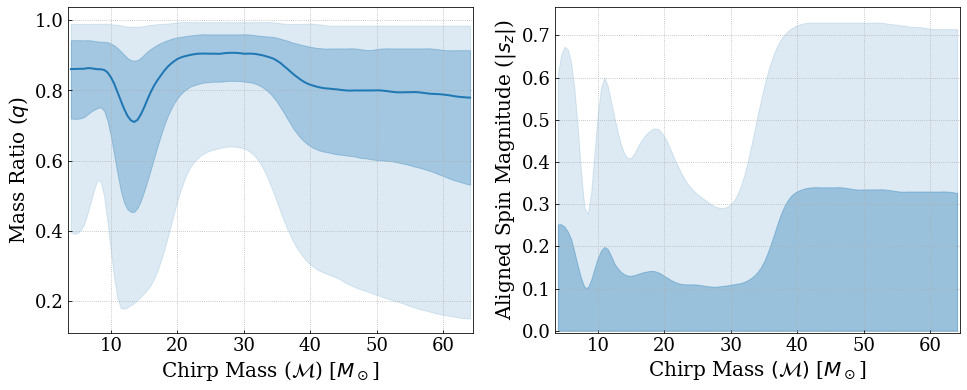

In [17]:
key = 'Mixed'
fig = plt.figure(figsize = (16.0, 6.0))
plt.subplot(1, 2, 1)
plt.plot(mchax, savgol_filter(p50_mchq, 9, 2), color = colours[key], linewidth = 2.0)
plt.fill_between(mchax, savgol_filter(p25_mchq, 9, 2), savgol_filter(p75_mchq, 9, 2), alpha = 0.3, color = colours[key])
plt.fill_between(mchax, savgol_filter(p5_mchq, 9, 2), savgol_filter(p95_mchq, 9, 2), alpha = 0.15, color = colours[key])
plt.grid(ls=':')
plt.xlabel('Chirp Mass ($\mathcal{M}$) [$M_\odot$]', fontsize=20)
plt.ylabel('Mass Ratio ($q$)', fontsize=20)
plt.xlim(mchax[0]-0.5, mchax[-1]+0.5)
plt.subplot(1, 2, 2)
plt.fill_between(mchax, np.zeros_like(mchax), savgol_filter(p50_mchsz, 9, 2), alpha = 0.35, color = colours[key])
plt.fill_between(mchax, np.zeros_like(mchax), savgol_filter(p90_mchsz, 9, 2), alpha = 0.15, color = colours[key])
plt.grid(ls=':')
plt.xlabel('Chirp Mass $(\mathcal{M})$ [$M_\odot$]', fontsize=20)
plt.ylabel('Aligned Spin Magnitude (|$s_z$|)', fontsize=20)
plt.xlim(mchax[0]-0.5, mchax[-1] + 0.5)
plt.ylim(-0.006, None)
plt.savefig(directory + '/q_and_sz_vs_mch.jpg', dpi = dpi, bbox_inches = 'tight')

### Some prints

In [18]:
ppd_mch = results['Mixed']['ppd']['ppd_mch']
ppd_q = results['Mixed']['ppd']['ppd_q']
ppd_s1z = results['Mixed']['ppd']['ppd_s1z']
ppd_z = results['Mixed']['ppd']['ppd_z']

idx = [np.random.choice(range(len(ppd_mch[ii])), size = int(rate[ii] * 20)) for ii in range(len(rate))]
ppd_mch_ratewise = np.concatenate([ppd_mch[ii][idx[ii]] for ii in range(len(rate))])
ppd_sz_ratewise = np.concatenate([ppd_s1z[ii][idx[ii]] for ii in range(len(rate))])
ppd_q_ratewise = np.concatenate([ppd_q[ii][idx[ii]] for ii in range(len(rate))])
ppd_z_ratewise = np.concatenate([ppd_z[ii][idx[ii]] for ii in range(len(rate))])
ppd_m1_ratewise, ppd_m2_ratewise = qmch_to_m1m2(ppd_mch_ratewise, ppd_q_ratewise)

#90% Confidence Intervals
print ('==== Rate ====')
p5, p50, p95 = np.percentile(rate, 5.), np.median(rate), np.percentile(rate, 95.)
print (np.round(p5, 2), '-' ,np.round(p95, 2))
print (np.round(p50, 2), '+',np.round(p95 - p50, 2), '-',np.round(p50 - p5, 2))
print ('Drop/Rise in Density near gap:', frac_drop, frac_rise)
print()
print ('==== Masses and Spins ====')
masses = np.append(ppd_m1_ratewise, ppd_m2_ratewise)
p1, p99 = np.percentile(masses, 1.), np.percentile(masses, 99.)
print ('Minimum Mass:', np.round(np.percentile(masses, 1.), 2))
print ('Mass - ratio:', np.round(np.percentile(ppd_q_ratewise, 5.),2), np.round(np.percentile(ppd_q_ratewise, 95.),2))
print ('Aligned Spin:', np.round(np.percentile(ppd_sz_ratewise, 5.),2), np.round(np.percentile(ppd_sz_ratewise, 95.),2))
print ()
print ('==== Masses vs Spins ====')
p5, p95 = np.percentile(ppd_sz_ratewise[ppd_mch_ratewise < 30], 5.), np.percentile(ppd_sz_ratewise[ppd_mch_ratewise < 30], 95.)
print ('Low Mass Spins:', np.round(p5, 2), np.round(p95, 2))
p5, p95 = np.percentile(ppd_sz_ratewise[ppd_mch_ratewise > 30], 5.), np.percentile(ppd_sz_ratewise[ppd_mch_ratewise > 30], 95.)
print ('Heavy Mass Spins:', np.round(p5, 2), np.round(p95, 2))
print()
print ('=== Redshift Evolution ===')
k_single = results['Single']['posteriors']['kappa']
print('kappa:', np.round([np.percentile(k_single, 50), np.percentile(k_single, 95), np.percentile(k_single, 5)], 1))
ppd_mch_loz = ppd_mch_ratewise[ppd_z_ratewise < 0.4]
ppd_mch_hiz = ppd_mch_ratewise[ppd_z_ratewise > 0.4]
lo_perc = np.round(100 * len(ppd_mch_loz[ppd_mch_loz > 37])/len(ppd_mch_loz), 2)
hi_perc = np.round(100 * len(ppd_mch_hiz[ppd_mch_hiz > 37])/len(ppd_mch_hiz), 2)
print ('Percentage contribution heavy binaries at low/high redshifts:', lo_perc, hi_perc)

==== Rate ====
11.63 - 26.91
17.84 + 9.06 - 6.21
Drop/Rise in Density near gap: 70.1 6.0

==== Masses and Spins ====
Minimum Mass: 4.78
Mass - ratio: 0.48 0.99
Aligned Spin: -0.41 0.39

==== Masses vs Spins ====
Low Mass Spins: -0.41 0.38
Heavy Mass Spins: -0.56 0.62

=== Redshift Evolution ===
kappa: [2.5 3.8 0.9]
Percentage contribution heavy binaries at low/high redshifts: 3.42 1.62


### Redshift evolution of merger rate

In [19]:
z_ax = np.expm1(np.linspace(np.log(1.), np.log(1. + 1.5), 500))
cz_ax = 0.5 * (z_ax[1:] + z_ax[:-1])
Rz = {}
key = 'Mixed'
res = results[key]
w = res['posteriors']['gwts']
rates = res['posteriors']['rate']
ngauss = res['args_sampler']['ngauss']
k_mixed = res['posteriors']['kappa']
Rz[key] = []
for ii in range(len(rates)):
    rz_mixture = 0
    for jj in range(ngauss):
        rz_mixture += w[ii][jj] * (1 + z_ax) ** k_mixed[ii][jj]
    Rz[key].append(rates[ii] * rz_mixture)
key = 'Single'
res = results[key]
k_single = np.hstack(res['posteriors']['kappa'])
rr = np.hstack(res['posteriors']['rate'])
Rz[key] = [rr[i] * (1 + z_ax) **  k_single[i] for i in range(len(k_single))]

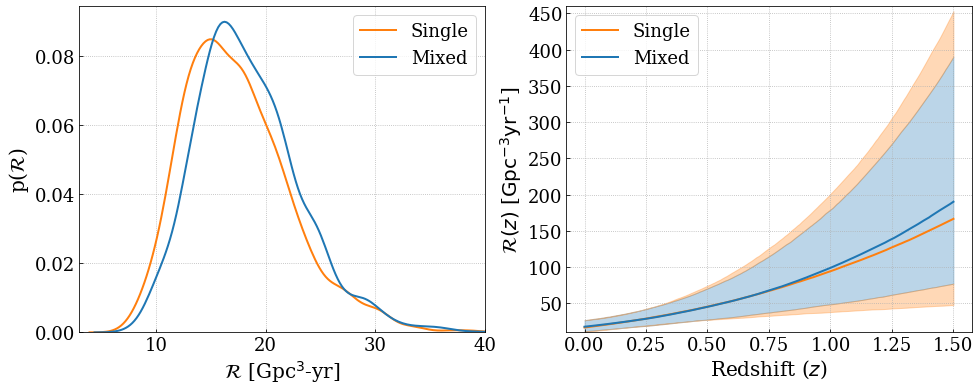

In [20]:
fig = plt.figure(figsize = (16., 6.))
plt.subplot(1, 2, 1)
for ii, key in enumerate(keys):
    rate = results[key]['posteriors']['rate']
    seaborn.kdeplot(rate, linewidth=2., label = key, color = colours[key])
plt.xlabel('$\mathcal{R}$ [Gpc$^3$-yr]', fontsize=20)
plt.ylabel('p($\mathcal{R}$)', fontsize=20)
plt.grid(ls=':')
plt.legend()
plt.xlim(3., 40.)
plt.subplot(1, 2, 2)
p5, p95 = {}, {}
for ii, key in enumerate(keys):
    R = Rz[key]
    p5[key], p50, p95[key] = np.percentile(R, 5., axis = 0), np.percentile(R, 50., axis = 0), np.percentile(R, 95., axis = 0)
    plt.plot(z_ax, p50, linewidth = 2., label = key, color = colours[key])
plt.fill_between(z_ax, p5['Mixed'], p95['Mixed'], alpha = 0.3, color = colours['Mixed'])
plt.fill_between(z_ax, p95['Mixed'], p95['Single'], alpha = 0.3, color = colours['Single'])
plt.fill_between(z_ax, p5['Mixed'], p5['Single'], alpha = 0.3, color = colours['Single'])

plt.xlabel('Redshift ($z$)', fontsize=20)
plt.ylabel('$\mathcal{R}(z)$ [$\mathrm{Gpc}^{-3} \mathrm{yr} ^{-1}$]', fontsize=20)
#plt.yscale('log')
plt.grid(ls=':')
plt.ylim(10.,460)
plt.legend(loc = 'upper left', fontsize = 18)
plt.savefig(directory + '/rate_zevol.jpg', dpi = dpi, bbox_inches = 'tight')

In [21]:
facs = {}
atz = .5
mchax = np.linspace(5., 68., 63 * 10 + 1)
cmchax = 0.5 * (mchax[1:] + mchax[:-1])

res = results['Single']
locmch = res['posteriors']['locs_mch']
stdmch = res['posteriors']['stds_mch']
kappamch = res['posteriors']['kappa']
rate = res['posteriors']['rate']
w = res['posteriors']['gwts']
facs['Single'] = []
for ii, r in enumerate(rate):
    f, p = 0, 0
    for n in range(ngauss):
        f += ss.norm.cdf(mchax, loc=locmch[ii][n], scale=stdmch[ii][n]) * w[ii][n] * (1 + atz) ** kappamch[ii]
        p += ss.norm.cdf(mchax, loc=locmch[ii][n], scale=stdmch[ii][n]) * w[ii][n]
    f = np.diff(f)
    p = np.diff(p)
    f /= p
    f[f!=f] = 0
    facs['Single'].append(f)

res = results['Mixed']
locmch = res['posteriors']['locs_mch']
stdmch = res['posteriors']['stds_mch']
kappamch = res['posteriors']['kappa']
rate = res['posteriors']['rate']
w = res['posteriors']['gwts']
facs['Mixed'] = []
for ii, r in enumerate(rate):
    f, p = 0, 0
    for n in range(ngauss):
        f += ss.norm.cdf(mchax, loc=locmch[ii][n], scale=stdmch[ii][n]) * w[ii][n] * (1 + atz) ** kappamch[ii][n]
        p += ss.norm.cdf(mchax, loc=locmch[ii][n], scale=stdmch[ii][n]) * w[ii][n]
    f = np.diff(f)
    p = np.diff(p)
    f /= p
    f[f!=f] = 0
    facs['Mixed'].append(f)

<ipython-input-21-8362fdd804eb>:20: RuntimeWarning: divide by zero encountered in true_divide
  f /= p
<ipython-input-21-8362fdd804eb>:20: RuntimeWarning: invalid value encountered in true_divide
  f /= p
<ipython-input-21-8362fdd804eb>:38: RuntimeWarning: divide by zero encountered in true_divide
  f /= p
<ipython-input-21-8362fdd804eb>:38: RuntimeWarning: invalid value encountered in true_divide
  f /= p


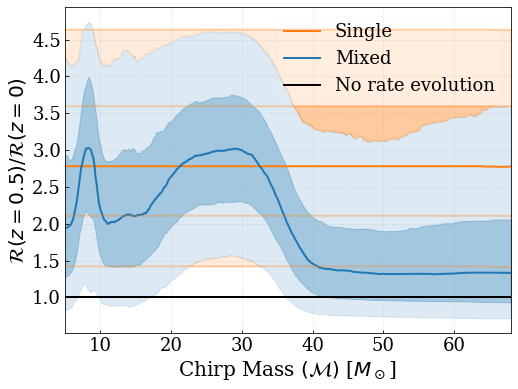

In [22]:
fig = plt.figure(figsize = (8., 6.))
p5, p25, p75, p95 = {}, {}, {}, {}
for ii, key in enumerate(facs.keys()):
    p50 = np.percentile(facs[key], 50., axis = 0)
    p5[key], p95[key] = np.percentile(facs[key], 5., axis = 0), np.percentile(facs[key], 95., axis = 0)
    p25[key], p75[key] = np.percentile(facs[key], 25., axis = 0), np.percentile(facs[key], 75., axis = 0)
    plt.plot(cmchax, p50, label = key, linewidth=2.0, color = colours[key])
key = 'Mixed'
plt.fill_between(cmchax, p5[key], p95[key], alpha=0.15, color = colours[key])
plt.fill_between(cmchax, p25[key], p75[key], alpha=0.3, color = colours[key])
key = 'Single'
plt.plot(cmchax, p5[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.plot(cmchax, p25[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.plot(cmchax, p75[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.plot(cmchax, p95[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.fill_between(cmchax, p95['Mixed'], p95['Single'], color = colours['Single'], where = (p95['Single'] > p95['Mixed']), alpha = 0.15)
plt.fill_between(cmchax, p95['Mixed'], p75['Single'], color = colours['Single'], where = (p75['Single'] > p95['Mixed']), alpha = 0.3)
plt.fill_between(cmchax, p5['Single'], p5['Mixed'], color = colours['Single'], where=(p5['Mixed'] > p5['Single']), alpha = 0.15)
plt.axhline(y=1.0, color = 'k', linewidth=2.0, label = 'No rate evolution')
plt.xlim(mchax[0], mchax[-1])
plt.xlabel('Chirp Mass $(\mathcal{M})$ [$M_\odot$]', fontsize=20)
plt.ylabel('$\mathcal{R}(z=' + str(atz) +')/\mathcal{R}(z=0)$', fontsize=20)
plt.xlim(mchax[0], mchax[-1])
plt.grid(ls=':', alpha = 0.5)
plt.legend(framealpha = 0.1, loc = 'upper right')
plt.savefig(directory + '/rate_vs_mch.jpg', dpi = dpi, bbox_inches = 'tight')

In [23]:
facs = {}
atz = .5
szax = np.linspace(-1, 1., 51)
cszax = 0.5 * (szax[1:] + szax[:-1])

res = results['Single']
locsz = res['posteriors']['locs_sz']
stdsz = res['posteriors']['stds_sz']
kappa = res['posteriors']['kappa']
rate = res['posteriors']['rate']
w = res['posteriors']['gwts']
facs['Single'] = []
for ii, r in enumerate(rate):
    f, p = 0, 0
    for n in range(ngauss):
        f += ss.norm.cdf(szax, loc=locsz[ii][n], scale=stdsz[ii][n]) * w[ii][n] * (1 + atz) ** kappa[ii]
        p += ss.norm.cdf(szax, loc=locsz[ii][n], scale=stdsz[ii][n]) * w[ii][n]
    f = np.diff(f)
    p = np.diff(p)
    f /= p
    f[f!=f] = 0
    facs['Single'].append(f)

res = results['Mixed']
locsz = res['posteriors']['locs_sz']
stdsz = res['posteriors']['stds_sz']
kappa = res['posteriors']['kappa']
rate = res['posteriors']['rate']
w = res['posteriors']['gwts']
facs['Mixed'] = []
for ii, r in enumerate(rate):
    f, p = 0, 0
    for n in range(ngauss):
        f += ss.norm.cdf(szax, loc=locsz[ii][n], scale=stdsz[ii][n]) * w[ii][n] * (1 + atz) ** kappa[ii][n]
        p += ss.norm.cdf(szax, loc=locsz[ii][n], scale=stdsz[ii][n]) * w[ii][n]
    f = np.diff(f)
    p = np.diff(p)
    f /= p
    f[f!=f] = 0
    facs['Mixed'].append(f)

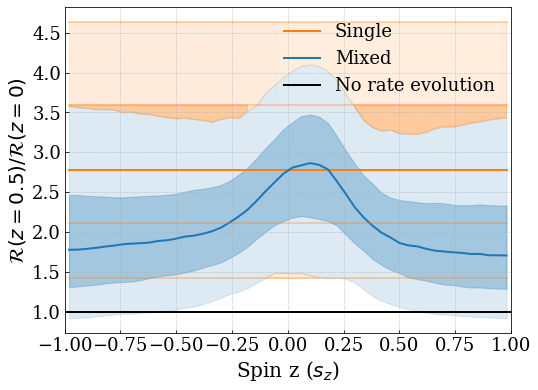

In [24]:
fig = plt.figure(figsize = (8., 6.))
p5, p25, p75, p95 = {}, {}, {}, {}
for ii, key in enumerate(facs.keys()):
    p50 = np.percentile(facs[key], 50., axis = 0)
    p5[key], p95[key] = np.percentile(facs[key], 5., axis = 0), np.percentile(facs[key], 95., axis = 0)
    p25[key], p75[key] = np.percentile(facs[key], 25., axis = 0), np.percentile(facs[key], 75., axis = 0)
    plt.plot(cszax, p50, label = key, linewidth=2.0, color = colours[key])
key = 'Mixed'
plt.fill_between(cszax, p5[key], p95[key], alpha=0.15, color = colours[key])
plt.fill_between(cszax, p25[key], p75[key], alpha=0.3, color = colours[key])
key = 'Single'
plt.plot(cszax, p5[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.plot(cszax, p25[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.plot(cszax, p75[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.plot(cszax, p95[key],linewidth=2.0, color = colours[key], alpha = 0.3)
plt.fill_between(cszax, p95['Mixed'], p95['Single'], color = colours['Single'], where = (p95['Single'] > p95['Mixed']), alpha = 0.15)
plt.fill_between(cszax, p95['Mixed'], p75['Single'], color = colours['Single'], where = (p75['Single'] > p95['Mixed']), alpha = 0.3)
plt.fill_between(cszax, p5['Single'], p5['Mixed'], color = colours['Single'], where=(p5['Mixed'] > p5['Single']), alpha = 0.15)
plt.axhline(y=1.0, color = 'k', linewidth=2.0, label = 'No rate evolution')
plt.xlim(szax[0], szax[-1])
plt.xlabel('Spin z ($s_z$)', fontsize=20)
plt.ylabel('$\mathcal{R}(z=' + str(atz) +')/\mathcal{R}(z=0)$', fontsize=20)
plt.xlim(szax[0], szax[-1])
plt.grid(ls=':')
plt.legend(framealpha = 0.1, loc = 'upper right')
plt.savefig(directory + '/rate_vs_sz.jpg', dpi = dpi, bbox_inches = 'tight')

### Predicted redshift distribution

In [25]:
#Predict observations from reconstructed population.
#Can take few mins
t0 = time.time()
nobs = {}
for obsrun in pe.keys():
    nobs[obsrun] = 0
    for obs in pe[obsrun].keys():
        nobs[obsrun] += 1

mch_pred_all, z_pred_all = {}, {}
for key in keys:
    res = results[key]
    nsel = int(10000/len(res['posteriors']['rate']) + 0.5)
    ngauss = res['args_sampler']['ngauss']
    rates = res['posteriors']['rate']
    locs_mch, stds_mch = res['posteriors']['locs_mch'], res['posteriors']['stds_mch']
    min_q, alphas_q = res['posteriors']['min_q'], res['posteriors']['alphas_q']
    locs_sz, stds_sz = res['posteriors']['locs_sz'], res['posteriors']['stds_sz']
    kappa, gwts = res['posteriors']['kappa'], res['posteriors']['gwts']
        
    mch_pred_all[key], z_pred_all[key] = [], []
    for jj in range(len(rates)):
        var_means, var_covs = functions.get_mchirp_spinz_params(locs_mch[jj], stds_mch[jj], locs_sz[jj], stds_sz[jj])
        for ii, injkey in enumerate(injections.keys()):
            log1pz = injections[injkey]['log1pz']
            mch_rec, logq_rec = injections[injkey]['mch_rec'], injections[injkey]['logq_rec']
            s1z_rec, s2z_rec = injections[injkey]['s1z_rec'], injections[injkey]['s2z_rec']
            z_rec = injections[injkey]['z_rec']
            parametric_data = np.transpose([mch_rec, s1z_rec, s2z_rec])
            dNdz = 0
            for kk in range(ngauss):
                logpdfq = models.powerlaw_logpdf(logq_rec, min_q[jj][kk], 1, alphas_q[jj][kk])
                logprob = models.core_logpdf(parametric_data, var_means[kk], var_covs[kk], logpdfq, gwts[jj][kk])
                
                if kappa.shape[-1] > 1:
                    dNdz += np.exp(logprob + kappa[jj][kk] * log1pz)
                else:
                    dNdz += np.exp(logprob + kappa[jj] * log1pz)
            dNdz /= injections[injkey]['rec_pdf']
            dNdz *= injections[injkey]['dilated_dcovdz']
            w = dNdz / np.sum(dNdz)
            idxx = np.random.choice(np.arange(len(mch_rec)), p = w, size = (nsel, nobs[injkey]))
            if ii == 0:
                mch_pred = mch_rec[idxx]
                z_pred = z_rec[idxx]
            else:
                mch_pred = np.hstack((mch_pred, mch_rec[idxx]))
                z_pred = np.hstack((z_pred, z_rec[idxx]))
                
        if jj == 0:
            mch_pred_all[key] = mch_pred
            z_pred_all[key] = z_pred
        else:
            mch_pred_all[key] = np.vstack((mch_pred_all[key], mch_pred))
            z_pred_all[key] = np.vstack((z_pred_all[key], z_pred))
print ('Execution Time:', np.round(time.time() - t0, 1))

Execution Time: 138.9


### Range of the Observed Redshifts

In [26]:
mchax = np.linspace(5., 68., 21)
cmchax = 0.5 * (mchax[1:] + mchax[:-1])
z_ax_c = 0.5 * (z_ax[1:] + z_ax[:-1])
counts = {}
for key in keys:
    counts[key], npost = [], mch_pred_all[key].shape[0]
    for ii in range(npost):
        n, _, _ = np.histogram2d(mch_pred_all[key][ii], z_pred_all[key][ii], bins = (mchax, z_ax))
        counts[key].append(n)

In [27]:
minz_p5, minz_p25, minz_p95 = {}, {}, {}
maxz_p5, maxz_p75, maxz_p95 = {}, {}, {}
medianz_p5, medianz_p50, medianz_p95 = {}, {}, {}
for key in keys:
    minz_p5[key], minz_p25[key], minz_p95[key] = [], [], []
    maxz_p5[key], maxz_p75[key], maxz_p95[key] = [], [], []
    medianz_p5[key], medianz_p50[key], medianz_p95[key] = [], [], []
    for ii, _ in enumerate(cmchax):
        minz, maxz, medianz = [], [], []
        for c in counts[key]:
            zpassed = z_ax_c[c[ii] > 0]
            if len(zpassed) > 0:
                minz.append(zpassed[0])
            if len(zpassed) > 0:
                maxz.append(zpassed[-1])
        
            if np.sum(c[ii]) > 0:
                zmean = np.sum(z_ax_c * c[ii]) / np.sum(c[ii])
                medianz.append(zmean)
                
        if len(minz) > 0:
            minz_p5[key].append(np.percentile(minz, 5.))
            minz_p25[key].append(np.percentile(minz, 25.))
            minz_p95[key].append(np.percentile(minz, 95.))
        else:
            minz_p5[key].append(0)
            minz_p25[key].append(0)
            minz_p95[key].append(0)
            
        if len(maxz) > 0:
            maxz_p5[key].append(np.percentile(maxz, 5.))
            maxz_p75[key].append(np.percentile(maxz, 75.))
            maxz_p95[key].append(np.percentile(maxz, 95.))
        else:
            maxz_p5[key].append(0)
            maxz_p75[key].append(0)
            maxz_p95[key].append(0)
          
        if len(medianz) > 0:
            medianz_p5[key].append(np.percentile(medianz, 5.))
            medianz_p50[key].append(np.percentile(medianz, 50.))
            medianz_p95[key].append(np.percentile(medianz, 95.))
        else:
            medianz_p5[key].append(0)
            medianz_p50[key].append(0)
            medianz_p95[key].append(0)

In [28]:
medianmch, medianz = [], []
zlow, zup = [], []
mchlow, mchup = [], []
for obsrun in pe.keys():
    for obs in pe[obsrun].keys():
        medianmch = np.append(medianmch, np.median(pe[obsrun][obs]['mchirp_src']))
        medianz = np.append(medianz, np.median(pe[obsrun][obs]['redshift']))
        zup.append(np.percentile(pe[obsrun][obs]['redshift'], 95.))
        zlow.append(np.percentile(pe[obsrun][obs]['redshift'], 5.))
        mchup.append(np.percentile(pe[obsrun][obs]['mchirp_src'], 95.))
        mchlow.append(np.percentile(pe[obsrun][obs]['mchirp_src'], 5.))

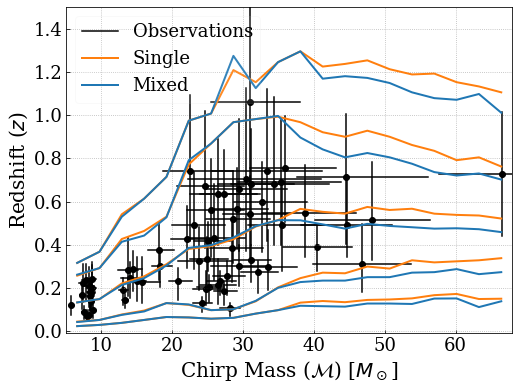

In [29]:
fig = plt.figure(figsize = (8.0, 6.0))
plt.scatter(medianmch, medianz, color = 'k')
for ii, mm in enumerate(medianmch):
    lbl = ''
    if ii == 0:
        lbl = 'Observations'
    plt.plot([medianmch[ii],medianmch[ii]],[zup[ii],zlow[ii]], color = 'k', label = lbl)
    plt.plot([mchlow[ii],mchup[ii]],[medianz[ii], medianz[ii]], color = 'k')
for key in keys:
    c = colours[key]
    plt.plot(cmchax, minz_p5[key], color = c, linewidth = 2.0)
    plt.plot(cmchax, minz_p25[key], color = c, linewidth = 2.0)
    plt.plot(cmchax, maxz_p95[key], color = c, linewidth = 2.0)
    plt.plot(cmchax, maxz_p75[key], color = c, linewidth = 2.0)
    plt.plot(cmchax, medianz_p50[key], color = c, linewidth = 2.0, label = key)
plt.grid(linestyle = ':')
plt.xlim(mchax[0], mchax[-1])
plt.ylim(-0.01, 1.5)
plt.legend(loc = 'upper left', fontsize = 18, framealpha = 0.1)
plt.xlabel('Chirp Mass ($\mathcal{M}$) [$M_\odot$]', fontsize=20)
plt.ylabel('Redshift ($z$)', fontsize=20)
plt.savefig(directory + '/z_vs_mch_pred_obs.jpg', dpi = dpi, bbox_inches = 'tight')

### $\kappa$: aggregate over peaks

In [30]:
locsmch = np.hstack(results['Mixed']['posteriors']['locs_mch'])
kappas = np.hstack(results['Mixed']['posteriors']['kappa'])
wts = np.hstack(results['Mixed']['posteriors']['gwts'])

In [31]:
brk = [5.2, 10., 18., 37., 67.]
for ii in range(len(brk) - 1):
    idxsel = np.where((locsmch >= brk[ii]) & (locsmch < brk[ii+1]))
    ksel = kappas[idxsel]
    wsel = wts[idxsel]
    repeat = (wsel/np.min(wsel) + 0.5).astype(int)
    data = np.repeat(ksel, repeat)
    p5, p50, p95 = np.percentile(data, 5.), np.percentile(data, 50.), np.percentile(data, 95.)
    p5 = np.round(p5, 1)
    p50 = np.round(p50, 1)
    p95 = np.round(p95, 1)
    print (p5, p50, p95)

-0.5 2.4 3.9
-0.8 1.4 3.7
-0.4 2.4 3.8
-0.9 0.1 2.5
